## Load Module

In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as ly

import os
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io as scio
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from collections import defaultdict
import _pickle as pickle

## Parameters

In [2]:
# Inputs:Global parameters 
batch_size = 32
img_dim = 688
z_dim = 110

# Define salient variable
cat_list = [] # Each entry in this list defines a categorical variable for specific size
cont_num = 1 # the number of continous variables

# Optimizer: whether use adam for parameters update , if flag is set false use tf.train.RMEPropOptimzer
is_adam = True
learning_rate_gen = 2e-4
learning_rate_dis = 2e-4
# the upper bound and lower bound in critic
clamp_lower =-0.01
clamp_upper = 0.01


# Train : Prameters
device = '/gpu:0'
data_format = 'NCHW'
channel = 1



# ERROR MAYBE HAPPEN

In [3]:
# directory to store log ,include loss  and grad_norm of generator and critic
rgan_dir = './Inproved_rgan/RGAN/Experient_8'

log_dir = rgan_dir + '/log_rgan'
ckpt_dir = rgan_dir + '/ckpt_rgan'
spec_dir = rgan_dir + '/spec_rgan'

In [4]:
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
else:
    shutil.rmtree(ckpt_dir)
    os.makedirs(ckpt_dir)
    
if not os.path.exists(spec_dir):
    os.makedirs(spec_dir)
else:
    shutil.rmtree(spec_dir)
    os.makedirs(spec_dir)

## Load dataset

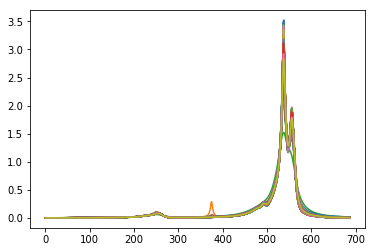

In [4]:
# from database load the data and label,clip the length network required
spect = scio.loadmat('NMR_Index.mat')
x,y = spect['NMR'],spect['Index'][:,3]
if x.shape[1]>img_dim:
    x = x[:,:img_dim]
# plot raw data    
plt.plot(x.transpose())
plt.show()

# pre_processing by minmaxmap
xmin, xmax, ymin, ymax = x.min(),x.max(), y.min(),y.max()
xmid,ymid = (xmin+xmax)/2,(ymin+ymax)/2
x,y = (x - xmid)*2/( xmax - xmin ),(y - ymid)*2/( ymax - ymin )

# reshape the data to the format that look like image
x= x.reshape(-1,1,img_dim,1)
y= y.reshape(-1,cont_num)

## split the dataset
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.20,random_state=0)

## Generator

In [5]:
def generator_conv(z):
    train = ly.fully_connected(z, 1024, activation_fn = tf.nn.relu, normalizer_fn=None)
    train = ly.fully_connected(train, 256*172, activation_fn = tf.nn.relu, normalizer_fn=None)
    train = tf.reshape(train,(-1,256,172,1))
    train = ly.conv2d_transpose(train, 128, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, 64, kernel_size=[5,1],stride=[2,1],data_format=data_format,
                                activation_fn = tf.nn.relu, normalizer_fn = ly.batch_norm, padding='SAME',
                                normalizer_params={'fused':True,'data_format':data_format,},
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    train = ly.conv2d_transpose(train, channel , kernel_size=[5,1],stride=[1,1],data_format=data_format,
                                activation_fn = tf.nn.tanh, padding='SAME',
                                weights_initializer = tf.random_normal_initializer(0,0.02))
    return train

## Discriminator

In [6]:
def lrelu(x,leak=0.2,name='lrelu'):
    with tf.variable_scope('lrelu'):
        f1 = 0.5*(1+leak)
        f2 = 0.5*(1-leak)
        return f1*x + f2*abs(x)

In [7]:
def critic_conv( x ,c ,cat_list =cat_list ,cont_num =cont_num,reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
        size = 16
        
        img_out = ly.conv2d(x,num_outputs=size*4,kernel_size=[10,1],stride=[2,1],padding='SAME',
                       activation_fn = lrelu,data_format=data_format,
                       weights_initializer = tf.random_normal_initializer(0,0.02))
        
        
        img = ly.conv2d(img_out,num_outputs= size*8 ,kernel_size=[10,1],stride=[2,1],padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        
        c = tf.tile(c,[1,int(img_dim/4)])
        c = tf.reshape(c,(batch_size,1,int(img_dim/4),1))
        img = tf.concat((c,img),axis=1)
        
        img = ly.conv2d(img ,num_outputs= size*16,kernel_size=[10,1],stride=[2,1],padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        
        
        # fully_connected
        disc_img = ly.flatten(img)
        disc_img = ly.fully_connected(disc_img,1024,activation_fn=lrelu)
        disc = ly.fully_connected(disc_img,1,activation_fn=None)
        
        # Here we difine the unique layers used for the q_network, the number of outputs 
        q_img = ly.conv2d(img_out,num_outputs= size*8,kernel_size=[10,1],stride=[1,1],padding='SAME',
                        activation_fn = lrelu,data_format=data_format,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format},
                        weights_initializer = tf.random_normal_initializer(0,0.02))
        
        q_img = ly.flatten(q_img)
        q_img = ly.fully_connected(q_img,1024,activation_fn=lrelu,normalizer_fn = ly.batch_norm,
                        normalizer_params ={'fused':True,'data_format':data_format})
        
        q_cat_outs = []
        if len(cat_list)>0:
            for idx,var in enumerate(cat_list):
                q_outA = ly.fully_connected(q_img,var, activation_fn=tf.nn.softmax)
                q_cat_outs.append(q_outA)
        
        q_cont_outs = []
        if cont_num>0:
            q_cont_outs = ly.fully_connected(q_img,cont_num,activation_fn = tf.nn.tanh)
    
    return disc, q_cat_outs, q_cont_outs

## Build Graph & Loss Function

In [8]:
def build_graph(is_test=False):
    ##########################  Inputs ######################################
    # Real data 
    real_data = tf.placeholder(dtype = tf.float32,shape=[None,channel,img_dim,1])
    real_label = tf.placeholder(dtype = tf.float32,shape = [None,cont_num])
    # Noise ;Continous variable, and rand variable to provide some variance
    z_cont = tf.placeholder(dtype = tf.float32,shape =[None,cont_num])
    z_rand = tf.placeholder(dtype =tf.float32,shape =[None,z_dim])
    # Categorical variable
    if len(cat_list)>0:
        z_cat = tf.placeholder(dtype = tf.int32, shape=[None,len(cat_list)])
        cat_var = tf.split(z_cat , len(cat_list),axis=1)

        cat_z =[]
        for idx ,depth in enumerate(cat_list):
            cat_temp = tf.one_hot(tf.reshape(cat_var[idx],[-1]), depth)
            cat_z.append(cat_temp)
    else:
        z_cat = tf.placeholder(dtype =tf.float32,shape =[None,10])
        cat_z = [z_cat]
    # Conbine all of the variable
    z = cat_z[:]
    z.append(z_cont)
    z.append(z_rand)
    z = tf.concat( z,axis=1)
    
    #########################  End Inputs #####################################
    
    ##########################  Graph   ######################################
    generator = generator_conv
    discriminator = critic_conv
    
    with tf.variable_scope('generator'):
        gen = generator(z)
    
    disc_real,cat_real,cont_real = discriminator(real_data,real_label)
    disc_fake,cat_fake,cont_fake = discriminator(gen,cont_real, reuse=True)

    # Wasserstein distance
    d_loss = tf.reduce_mean(disc_fake - disc_real)
    g_loss = tf.reduce_mean( - disc_fake)
    g_loss_summ = tf.summary.scalar('wasserstein_loss_g' , g_loss)
    d_loss_summ = tf.summary.scalar('wasserstein_loss_d' , -d_loss)
    
    # Combine losses for each of categorical variables
    if len(cat_list)>0:
        cat_losses_f =[]
        tiny = 1e-10
        for idx,var in enumerate(cat_z):
            cat_loss_f = -tf.reduce_sum(var *tf.log(cat_fake[idx]+tiny),reduction_indices=1)
            cat_losses_f.append(cat_loss_f)
            # cat_losses_r 
    else:
        cat_losses_f=cat_losses_r = tf.constant(0.0)
    # Combine losses for each of continous variables
    # MSE
    if cont_num>0:
        cont_loss_f = tf.reduce_mean(tf.reduce_sum(tf.square(cont_fake-z_cont),reduction_indices=1))
        cont_loss_r = tf.reduce_mean(tf.reduce_sum(tf.square(cont_real- real_label),reduction_indices=1))
    else:
        cont_loss_f = cont_loss_r = tf.constant(0.0)
    
    # Loss balance parameter
    alpha = 1
    q_cont_loss = cont_loss_r + alpha* cont_loss_f
    q_cat_loss = tf.constant(0.0)
    q_loss = tf.add(q_cont_loss,q_cat_loss)
    
    # Total variation loss
    tv_loss = tf.nn.l2_loss(gen[:,:,1:,:]-gen[:,:,:img_dim-1,:])/batch_size
    
    # Loss of Discriminator and Generator, Discriminator train on True and False data
    loss_gen = g_loss + 0.000 *cont_loss_f + 0.000 * tv_loss
    loss_dis = d_loss
    loss_qnt = cont_loss_r
    
    loss_gen_summ = tf.summary.scalar('generator_loss',loss_gen)
    loss_dis_summ = tf.summary.scalar('discriminator_loss',loss_dis)
    ########################### End Graph   ######################################
    if is_test:
        return gen,z_rand,z_cont,z_cat,cont_real,cont_loss_r,real_data,real_label
    
    ##################### Optimization ########################################
    # Variable Collection
    theta_g = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='generator')
    theta_d = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='discriminator')
    theta_c = theta_d[10:]
    theta_d = theta_d[:10]

    # Optimizers
    counter_g = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_g = optimize(loss = loss_gen,variables=theta_g, learning_rate = learning_rate_gen,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    global_step=counter_g,summaries=['gradient_norm','gradients'])
    
    counter_d = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_d = optimize(loss =loss_dis,variables=theta_d ,learning_rate = learning_rate_dis,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    global_step=counter_d,summaries=['gradient_norm','gradients'])
    
    counter_q = tf.Variable(trainable=False , initial_value=0,dtype=tf.int32)
    opt_q = optimize(loss =loss_qnt ,variables=theta_c ,learning_rate = learning_rate_dis,
                    optimizer=tf.train.AdamOptimizer if is_adam is True else tf.train.RMSPropOptimizer,
                    global_step=counter_d,summaries=['gradient_norm','gradients'])
    # Clip weights
    clipped_var_d = [tf.assign(var,tf.clip_by_value(var,clamp_lower,clamp_upper)) for var in theta_d]
    with tf.control_dependencies([opt_d]):
        opt_d = tf.tuple(clipped_var_d)
    ################################# End Optimization ################################################
    return opt_d, opt_g ,opt_q,real_data,real_label,z_rand,z_cont,z_cat,loss_dis,loss_gen,loss_qnt,gen,q_cont_loss,q_cat_loss

####  Optimizer

In [9]:
def optimize(loss,learning_rate, optimizer,variables,global_step,summaries):
    optim = optimizer(learning_rate=learning_rate)
    
    # Caculate gradients
    gradients = optim.compute_gradients(loss,var_list = variables)
    
    # Add summary
    if summaries is None:
        summaries = ['loss','learning_rate']
    if 'gradient_norm'  in summaries:
        tf.summary.scalar('global_norm/gradient_norm',tf.global_norm(list(zip(*gradients))[0]))
        
    if 'loss' in summaries:
        tf.summary.scalar('loss',loss)
    
    for gradient,variable in gradients:
        if isinstance(gradient,tf.IndexedSlices):
            grad_values = gradient.values
        else:
            grad_values = gradient
        
        if grad_values is not None:
            var_name = variable.name.replace(':','_')
            if 'gradients' in summaries:
                tf.summary.histogram('gradients/%s'%var_name, grad_values)
            
            if 'gradient_norm' in summaries:
                tf.summary.scalar('gradient_norm/%s'%var_name,tf.global_norm([grad_values]))
    return optim.apply_gradients(gradients,global_step=global_step)
        

## Plot

In [11]:
def save_image(specs ,size,i =100,image_path = rgan_dir):
    _,ax = plt.subplots(size[0],size[1],sharex = True,sharey = True)
    for i in range(size[0]):
        for j in range(size[1]):
            ax[i][j].plot(np.arange(specs.shape[1]),specs[i*10+j] ,'-*')
    
    plt.savefig(image_path+'/'+str(i).zfill(4)+'.png')
    plt.close()

In [12]:
def save_spectrum(gen, i,spec_size = 10,is_show=False):
    if gen.shape[0]<spec_size:
        spec_size = gen.shape[0]

    gen = gen[:spec_size]
    # control the spect limitation and intv determine the the distance of spectrums
    intv = 0
    scale = 3.9
    # extend along y axis to visulize the difference between spetrum
    if is_show:
        extd = np.matlib.repmat(np.arange(0,spec_size),img_dim,1) 
        extd = extd * scale*intv
    else:
        extd = np.zeros((img_dim, spec_size))
    # convert data to ideal format 
    def cv_proc(x):
        x = xmid + x*(xmax-xmin)/2
        return x
        
    spec = cv_proc(gen.reshape(spec_size,img_dim))
    spec = spec.transpose() + extd
    
    # plot the spectrum with ylimit legend and other thing
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(spec.shape[0]),spec ,'-*')    
    plt.legend([np.array_str(var) for var in np.arange(spec_size)])
    if intv ==0:
        plt.ylim([-0.5,scale])
    else:
        plt.ylim([-0.5,scale*spec_size*intv])
    
    
    if is_show:
        return plt.show()
    # savefig
    plt.savefig(spec_dir+'/'+str(i).zfill(4)+'.png')
    plt.close('all')

## Condictional WGAN Subphase 

In [13]:
def train_rgan(max_epochs = 1000):
    # build graph
    with tf.device(device):
        opt_d, opt_g ,opt_q,real_data,real_label,z_rand,z_cont,z_cat,\
        loss_dis,loss_gen,loss_qnt,gen,q_cont_loss,q_cat_loss = build_graph()
        
    saver = tf.train.Saver()

    def next_feed_dict(iter, shuffled = True,is_test =False):
        
        # feed image and label,train set if is_test=False
        # otherwise test set
        def generate_index(input,iter,shuffled =shuffled):
            input_number = input.shape[0]
            if shuffled:
                idx = np.random.randint(input_number,size=(batch_size,))
            else:
                bat_num = int(input_number/batch_size)
                par = int(iter % bat_num)
                idx = np.arange(input_number)[par * batch_size:(par+1)*batch_size]
            return idx
        
        if is_test:
            idx = generate_index(x_test,iter)
            feed_img,feed_label = x_test[idx],y_test[idx]
        else:
            idx = generate_index(x_train,iter)
            feed_img,feed_label = x_train[idx],y_train[idx]
        
        # False data which sigma = 0.3 mean most of point located in the [-1,1].
        batch_z_rand = np.random.normal(0,0.3,[batch_size,z_dim]).astype(np.float32)
        if len(cat_list)>0:
            batch_z_cat  = np.random.randint(0,10,[batch_size,len(cat_list)])
        else:
            batch_z_cat = np.random.normal(0,0.3,[batch_size,10]).astype(np.float32)
        
        batch_z_cont = np.random.uniform(-1,1,[batch_size,cont_num])     
        
        feed_dict = {real_data:feed_img, 
                     z_rand : batch_z_rand,
                     z_cat  : batch_z_cat,
                     z_cont : feed_label,
                     real_label:feed_label }
        return feed_dict
    
    config = tf.ConfigProto(allow_soft_placement = True,log_device_placement=True)
    config.gpu_options.allow_growth =True
    config.gpu_options.per_process_gpu_memory_fraction=0.9
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        
        # use two dict-like container to record of history data
        # for analysising the result
        history = defaultdict(list)
        # Every epoch have n iterations for sampling randomly
        train_epoch_iters = int(x_train.shape[0]/batch_size)+1
        test_epoch_iters = int(x_test.shape[0]/batch_size)+1
        
        for i in range(max_epochs):
            
            start_time = time.time()
            ## Training Phase
            train_history = []
            for j in range(train_epoch_iters):
            
                feed_dict = next_feed_dict(i*train_epoch_iters+j)
                # for evaluation 
                _,dLoss = sess.run([opt_d,loss_dis],feed_dict = feed_dict)
                _,gLoss,spec = sess.run([opt_g,loss_gen,gen],feed_dict = feed_dict)
                _,qLoss,qCont,qCat = sess.run([opt_q, loss_qnt,q_cont_loss,q_cat_loss],feed_dict = feed_dict)
            
                train_history.append([dLoss,gLoss,qLoss,qCont,qCat])
            
            history['train_loss'].append(np.mean(np.array(train_history),axis=0))
            ## Testing Phase
            test_history = []
            for k in range(test_epoch_iters):
                feed_dict = next_feed_dict(i*test_epoch_iters+k,is_test=True)

                dLoss_ = sess.run(loss_dis,feed_dict = feed_dict)
                gLoss_ = sess.run(loss_gen,feed_dict = feed_dict)
                qLoss_ ,qCont_ ,qCat_ = sess.run([loss_qnt,q_cont_loss,q_cat_loss],feed_dict = feed_dict)
                
                test_history.append([dLoss,gLoss,qLoss,qCont,qCat])
            
            history['test_loss'].append(np.mean(np.array(test_history),axis=0))
            
            if i % 10 == 0:
                elapse = time.time() - start_time
                time_left = (max_epochs-i-1)* elapse
                print('\nIteration: {:0>4d}({:0.2%}) of {} \t Time left:{:02d}:{:02d}:{:02d}'.format(i,i/max_epochs,max_epochs,\
                     int(time_left/3600),int(time_left%3600/60),int(time_left%60)))
                
                print('{0:<8s} | {1:<15s} | {2:<15s} | {3:<15s} | {4:<15s} | {5:<15s}'\
                    .format('Loss','generator','discriminator','Q network','Q_continous','Q_categorical'))
                print('-' * 98)
                row_fmt = '{0:<8s} | {1:<15.3f} | {2:<15.3f} | {3:<15.3f} | {4:<15.3f} | {5:<15.3f}'
                print(row_fmt.format('train',*history['train_loss'][-1]))
                print(row_fmt.format('test' ,*history['test_loss'][-1]))
                save_spectrum(spec, i)
                
        

            if i %100 ==0:
                saver.save(sess, os.path.join(ckpt_dir,'model_checkpoint'),global_step=i)
            
        pickle.dump(history,open(rgan_dir+'/rgan_pickle.pkl','wb'))
            

In [14]:
tf.reset_default_graph()
train_rgan(max_epochs= 3000)


Iteration: 0000(0.00%) of 3000 	 Time left:02:39:50
Loss     | generator       | discriminator   | Q network       | Q_continous     | Q_categorical  
--------------------------------------------------------------------------------------------------
train    | -19.759         | 10.343          | 0.522           | 1.531           | 0.000          
test     | -49.027         | 22.978          | 0.193           | 1.182           | 0.000          

Iteration: 0010(0.33%) of 3000 	 Time left:02:05:53
Loss     | generator       | discriminator   | Q network       | Q_continous     | Q_categorical  
--------------------------------------------------------------------------------------------------
train    | -454.565        | 137.838         | 0.100           | 0.993           | 0.000          
test     | -509.728        | 182.998         | 0.090           | 1.056           | 0.000          

Iteration: 0020(0.67%) of 3000 	 Time left:02:00:03
Loss     | generator       | discriminator   | Q 

### Show the result

In [15]:
hist = pickle.load(open(rgan_dir+'/rgan_pickle.pkl','rb'))

In [16]:
losses = ['generator','discriminator','Q network','Q_continous','Q_categorical']

Use pandas to realize the two demensional dict-like tabular.

In [17]:
for p in hist.keys():
    hist[p] = pd.DataFrame(hist[p],columns=losses)

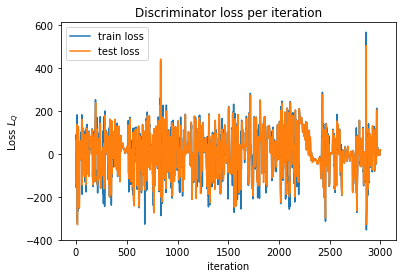

In [18]:
for p in hist.keys():
    plt.plot(hist[p]['discriminator'],label = '{}'.format(p))
plt.legend(['train loss','test loss'])
plt.title('Discriminator loss per iteration')
plt.xlabel('iteration')
plt.ylabel(r'Loss $L_Q$ ')
plt.show()

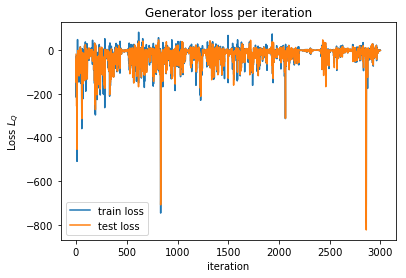

In [19]:
for p in hist.keys():
    plt.plot(hist[p]['generator'],label = '{}'.format(p))
plt.legend(['train loss','test loss'])
plt.title('Generator loss per iteration')
plt.xlabel('iteration')
plt.ylabel(r'Loss $L_Q$ ')
plt.show()

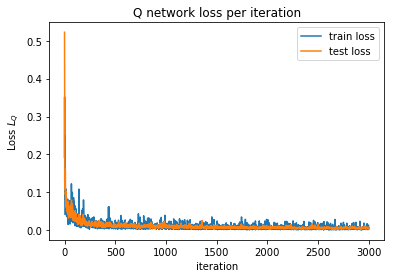

In [20]:
for p in hist.keys():
    plt.plot(hist[p]['Q network'],label = '{}'.format(p))
plt.legend(['train loss','test loss'])
plt.title('Q network loss per iteration')
plt.xlabel('iteration')
plt.ylabel(r'Loss $L_Q$ ')
plt.show()

### For test

In [10]:
def test(ckpt_dir=ckpt_dir):
    
    with tf.Session(config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=True)) as sess:
        # build graph
        with tf.device(device):
            gen,z_rand,z_cont,z_cat,cont_real,cont_loss_r,real_data,real_label = build_graph(is_test=True)
        
        # use saver to reload the parametes
        saver = tf.train.Saver()
        #saver.restore(sess, './Inproved_rgan/cgan_2d/Experient_1/ckpt_rgan\\model_checkpoint-17000')
        #saver.restore(sess,ckpt_dir+'\\model_checkpoint-18000')
        saver.restore(sess,tf.train.latest_checkpoint(ckpt_dir))
        ###########################################  Experiment : Generator #################
        ################################### Input ####################
        # Gererate random labels as conditions , [0,1] gausson distribution
        gen_number = 10*batch_size
        z_rand_sample = np.random.normal(0,0.3,[gen_number,z_dim])             
        z_cat_sample = np.random.normal(0,0.3,[gen_number,10])
        #z_cont_sample = np.zeros((batch_size,cont_num))
        z_cont_sample = np.linspace(-1,1,gen_number).reshape([gen_number,1])
        
        ################################### End Input ####################

        gens = sess.run(gen,{z_rand:z_rand_sample,
                                z_cat:z_cat_sample,
                                z_cont:z_cont_sample})
        
        def cv_proc(x):
            x = xmid + x*(xmax-xmin)/2
            return x
        
        spec = cv_proc(gens.reshape(gen_number,img_dim))
        spec = spec.transpose()
        
        fig = plt.figure(figsize=(4,3), dpi=500, facecolor="white")
        # plot raw data 
        plt.plot(np.arange(688),spec,'-',linewidth=0.7)
        plt.xlabel('Chemical Shift/ppm',fontsize=8)
        plt.ylabel(r'Intensity ',fontsize=8)
        plt.xticks(fontsize = 7)
        plt.yticks(fontsize = 7)
        plt.savefig(log_dir+'/spect.png')
        plt.show()
        ############################################  Experiment : Predict ##################
        def cv_proc(y):
            y = ymid + y*(ymax-ymin)/2
            return y
        
        def mse(y,y_predict):
            return np.mean(np.square(y-y_predict))
            
        
        Hist_predict = defaultdict(list)
        # Prediction & R2 score 
        y_train_true,y_test_true = cv_proc(y_train),\
                                   cv_proc(y_test)
        y_train_predict,y_test_predict = cv_proc(sess.run(cont_real,{real_data:x_train,real_label:y_train})),\
                                         cv_proc(sess.run(cont_real,{real_data:x_test,real_label:y_test}))
        r_train,r_test = r2_score(y_train_true,y_train_predict),\
                         r2_score(y_test_true,y_test_predict)
        mse_train,mse_test = mse(y_train_true,y_train_predict),\
                             mse(y_test_true,y_test_predict)
        # Restore
        Hist_predict['Training'] = [y_train_predict,y_train_true]
        Hist_predict['Testing'] =  [y_test_predict ,y_test_true]
        Hist_predict['r2_score'] = [r_train, r_test,mse_train,mse_test]
        
        pickle.dump(Hist_predict,open(rgan_dir+'/predict_rgan_pickle.pkl','wb'))
        
    return Hist_predict

INFO:tensorflow:Restoring parameters from ./Inproved_rgan/RGAN/Experient_8/ckpt_rgan\model_checkpoint-2900


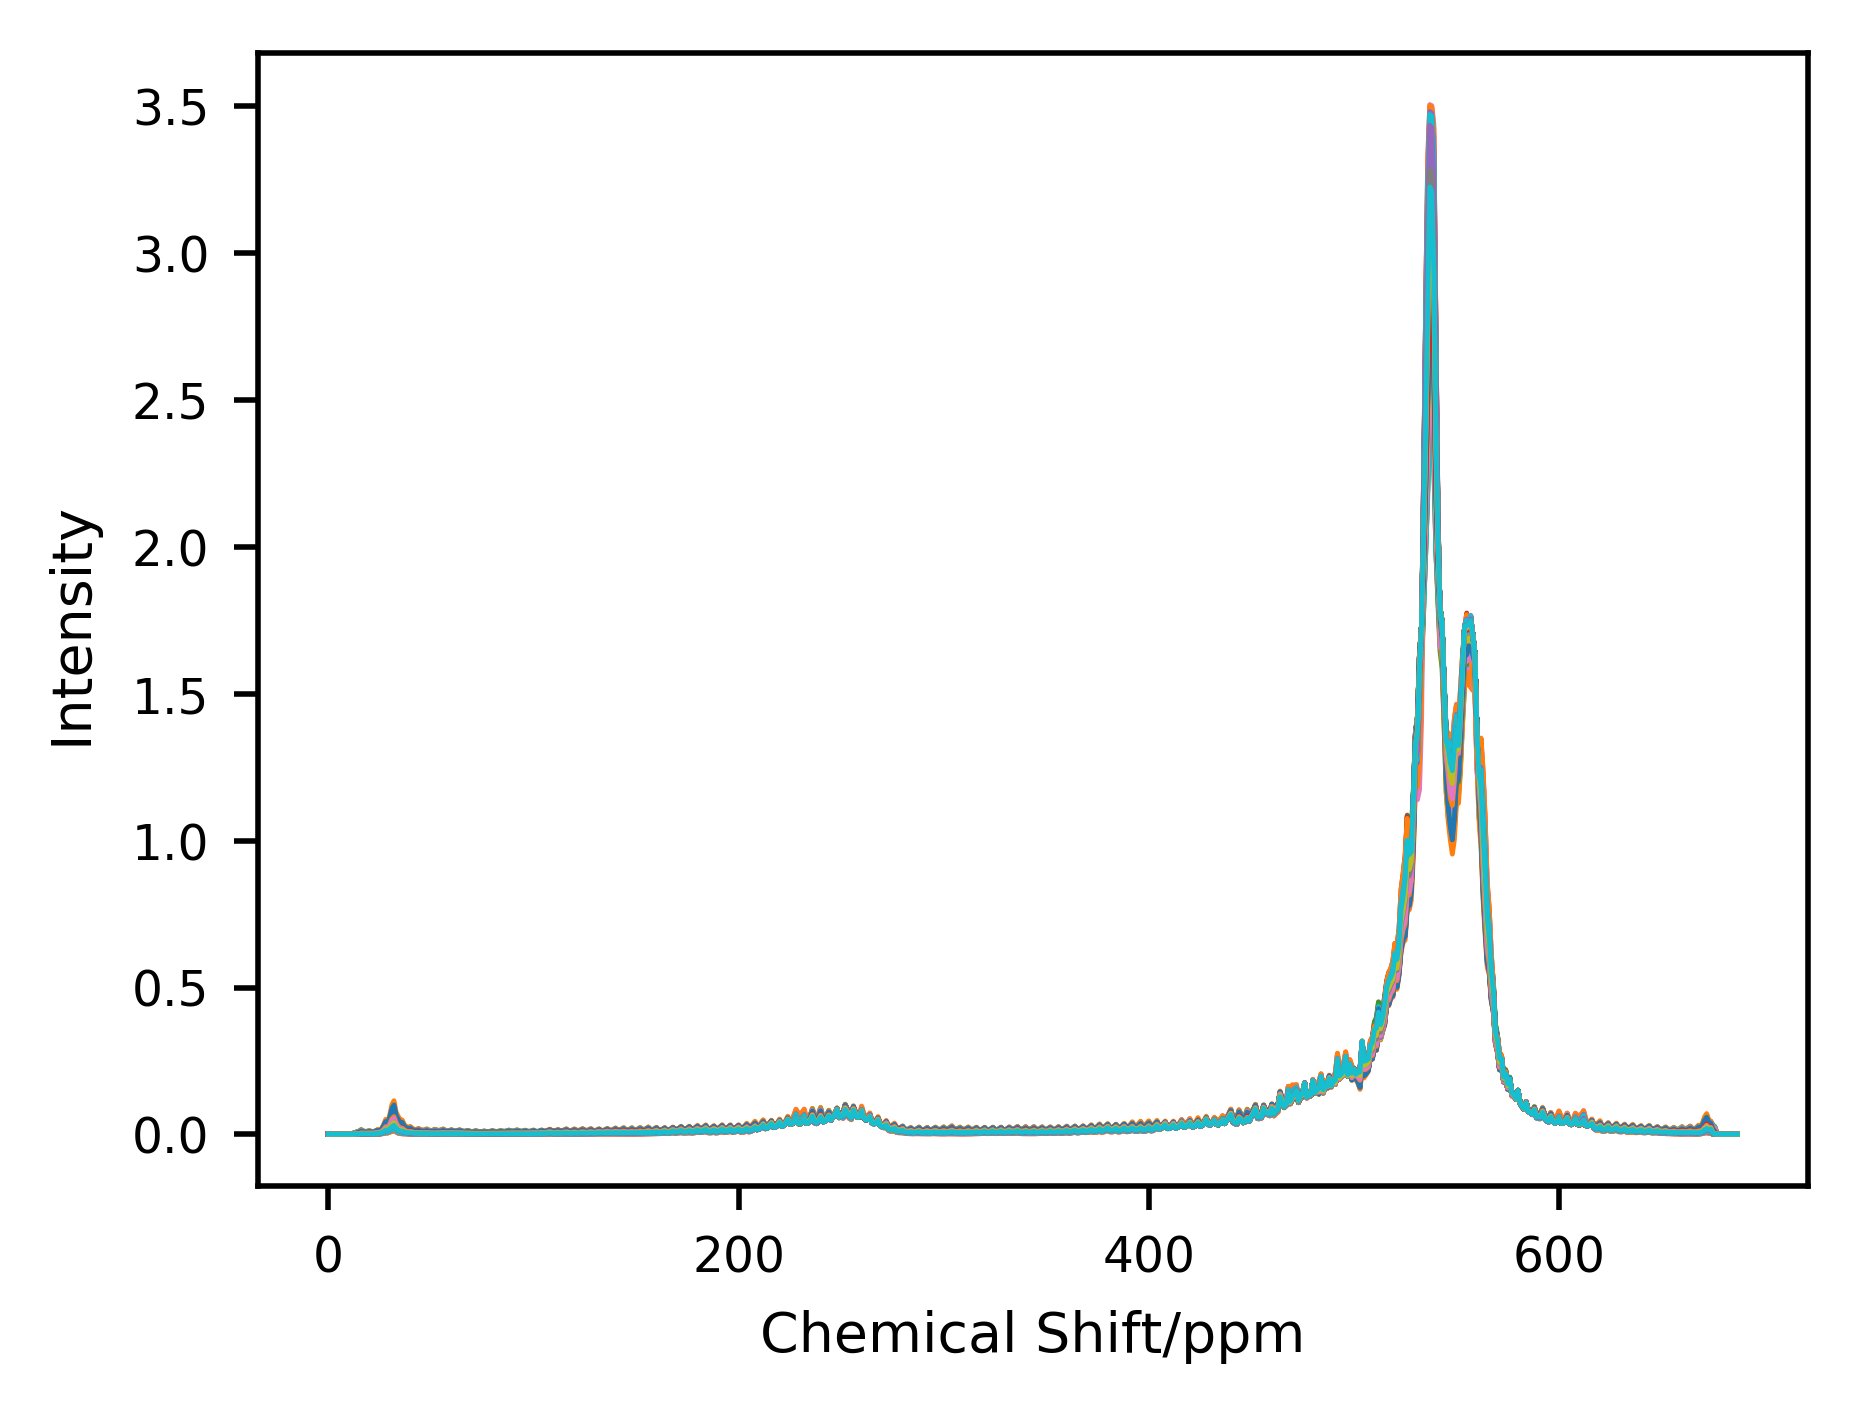

In [13]:
tf.reset_default_graph()
Hist_predict = test()

In [23]:
print('r -> {:.3f} | {:.3f}| {:.3f}| {:.3f}'.format(*Hist_predict['r2_score']))

r -> 0.981 | 0.744| 0.002| 0.028


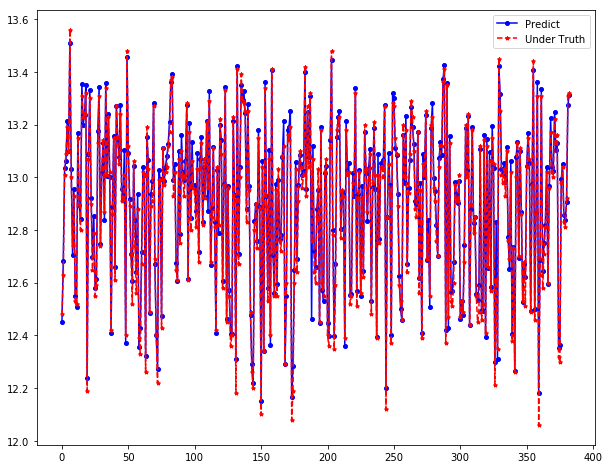

In [24]:
y_train_ = Hist_predict['Training']
x_limit = np.arange(len(y_train_[1]))
plt.figure(figsize=[10,8])
plt.plot(x_limit,y_train_[0],'b-o',x_limit,y_train_[1],'--r*',ms=4)
plt.legend(['Predict','Under Truth'])
plt.show()

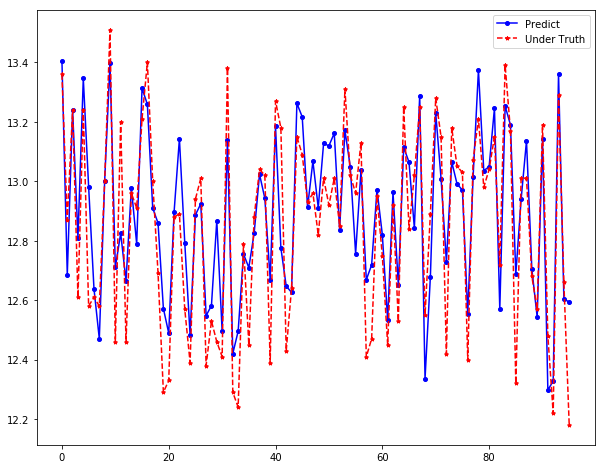

In [25]:
y_test_ = Hist_predict['Testing']
x_limit = np.arange(len(y_test_[1]))
plt.figure(figsize=[10,8])
plt.plot(x_limit,y_test_[0],'b-o',x_limit,y_test_[1],'--r*',ms=4)
plt.legend(['Predict','Under Truth'])
plt.show()